In [ ]:
%pip install osmnx networkx matplotlib smolagents

In [12]:
import os
import osmnx as ox
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from difflib import get_close_matches
from smolagents import CodeAgent, LiteLLMModel, Tool, FinalAnswerTool

### Construção e visualização do grafo

In [4]:
filter = '["highway"~"primary|secondary|tertiary"]'

place_name = "Belo Horizonte, Minas Gerais, Brasil"

G = ox.graph.graph_from_place(
    place_name, custom_filter=filter, network_type="walk"
)

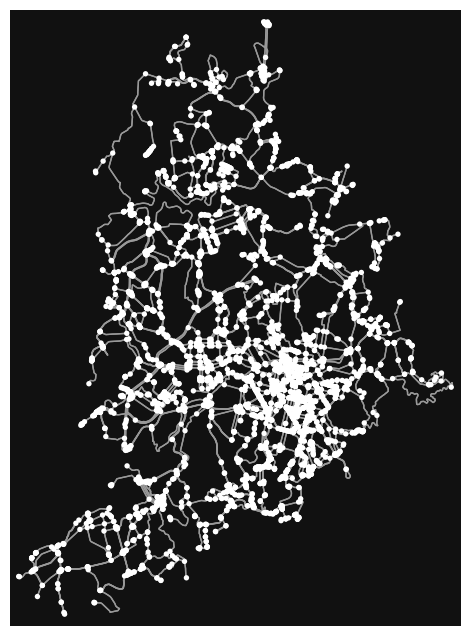

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
ox.plot_graph(G)

### Extração de restaurantes

In [6]:
restaurants = ox.features_from_place(place_name, {"amenity": "restaurant"})
restaurant_points = restaurants.representative_point()
nearest_nodes = ox.distance.nearest_nodes(
    G, restaurant_points.x, restaurant_points.y)

useful_tags = ["amenity", "name", "cuisine"]
restaurant_name_to_node = {}

for node, feature in zip(nearest_nodes, restaurants[useful_tags].to_dict(orient="records")):
    feature = {k: v for k, v in feature.items() if pd.notna(v)}
    if "name" in feature:
        restaurant_name_to_node[feature["name"].lower()] = node
    if "restaurants" not in G.nodes[node]:
        G.nodes[node]["restaurants"] = []
    G.nodes[node]["restaurants"].append(feature)

### Funções de busca

In [7]:
def bfs_path(G, source, target):
    try:
        # Peso não é passado para a função -> faz BFS
        return nx.shortest_path(G, source, target)
    except nx.NetworkXNoPath:
        return None


def a_star_path(G, source, target):
    try:
        return nx.astar_path(G, source, target, weight='length')
    except nx.NetworkXNoPath:
        return None


def shortest_path(source, target):
    def get_node_from_input(user_input):
        if user_input.lower() in restaurant_name_to_node:
            return restaurant_name_to_node[user_input.lower()]
        try:
            point = ox.geocode(user_input + ", " + place_name)
            return ox.distance.nearest_nodes(G, point[1], point[0])
        except Exception as e:
            return None

    source_node = get_node_from_input(source)
    if source_node is None:
        return None, None, f"Local de origem '{source}' não encontrado."

    target_node = get_node_from_input(target)
    if target_node is None:
        return None, None, f"Local de destino '{target}' não encontrado."

    bfs_route = bfs_path(G, source_node, target_node)
    a_star_route = a_star_path(G, source_node, target_node)

    return bfs_route, a_star_route, None

### Visualização da rota

In [8]:
def plot_routes(route1, route2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plotar grafo de Belo Horizonte nos dois eixos
    ox.plot_graph(G, ax=ax1, show=False, close=False,
                  edge_color='gray', node_size=0)
    ox.plot_graph(G, ax=ax2, show=False, close=False,
                  edge_color='gray', node_size=0)

    # Plotar rota BFS em azul
    if route1:
        ox.plot_graph_route(G, route1, ax=ax1, route_color='blue',
                            route_linewidth=4, show=False, close=False)
        ax1.set_title("BFS Route")
    else:
        ax1.set_title("BFS Route (no path)")

    # Plotar rota A* em vermelho
    if route2:
        ox.plot_graph_route(G, route2, ax=ax2, route_color='red',
                            route_linewidth=4, show=False, close=False)
        ax2.set_title("A* Route")
    else:
        ax2.set_title("A* Route (no path)")

    plt.tight_layout()
    plt.show()

### Formatação da rota

In [9]:
def format_route(route):
    if isinstance(route, str):
        return route
    coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in route]
    coords_str = ", ".join([f"({y:.5f}, {x:.5f})" for y, x in coords])
    return f"Path with {len(coords)} points: {coords_str}"

### Integração com agente

In [13]:
class FindRouteTool(Tool):
    name = "plan_route"
    description = "Use this tool to find a route between two locations in Belo Horizonte, either by name or adress"

    inputs = {
        "source": {"type": "string", "description": "The starting location (e.g. restaurant name or address)"},
        "target": {"type": "string", "description": "The destination location (e.g. restaurant name or address)"}
    }
    output_type = "string"

    def forward(self, source, target):
        # Corrigir erro de digitação nos nomes de restaurantes conhecidos
        source_corrected = self._corrigir_nome(source)
        target_corrected = self._corrigir_nome(target)
        
        bfs_route, a_star_route, erro = shortest_path(
            source_corrected, target_corrected)
        
        if erro:
            return f"Erro: {erro} Tente usar um nome de restaurante conhecido ou endereço válido em Belo Horizonte"
        
        if not bfs_route or not a_star_route:
            return FinalAnswerTool().forward(f"Não foi possível encontrar um caminho entre '{source}' e '{target}'")
        
        plot_routes(bfs_route, a_star_route)
        
        resposta = (f"Rotas encontradas entre '{source}' e '{target}':\n\n"
                    f"BFS Route:\n{format_route(bfs_route)}\n\n"
                    f"A* Route:\n{format_route(a_star_route)}")
        return FinalAnswerTool().forward(resposta)
    
    def _corrigir_nome(self, nome):
        nome_lower = nome.lower()
        nomes_conhecidos = list(restaurant_name_to_node.keys())
        correspondencias = get_close_matches(
            nome_lower, nomes_conhecidos, n=1, cutoff=0.75)
        return correspondencias[0] if correspondencias else nome


model = LiteLLMModel(
    model_id="ollama/qwen3:4b",
    api_base="http://localhost:11434",
    max_ctx=8192,
)

agent = CodeAgent(tools=[FindRouteTool()], model=model, add_base_tools=False)

Olá! Eu sou um agente inteligente de rotas para Belo Horizonte.
Posso traçar caminhos entre restaurantes ou locais da cidade usando algoritmos de busca como BFS e A*.
Basta me dizer de onde você quer sair e para onde deseja ir!


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Quero ir de Xapuri para Maria das Tranças                                                                       │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:4b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = plan_route(source="Xapuri", target="Maria das Tranças")                                                  
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

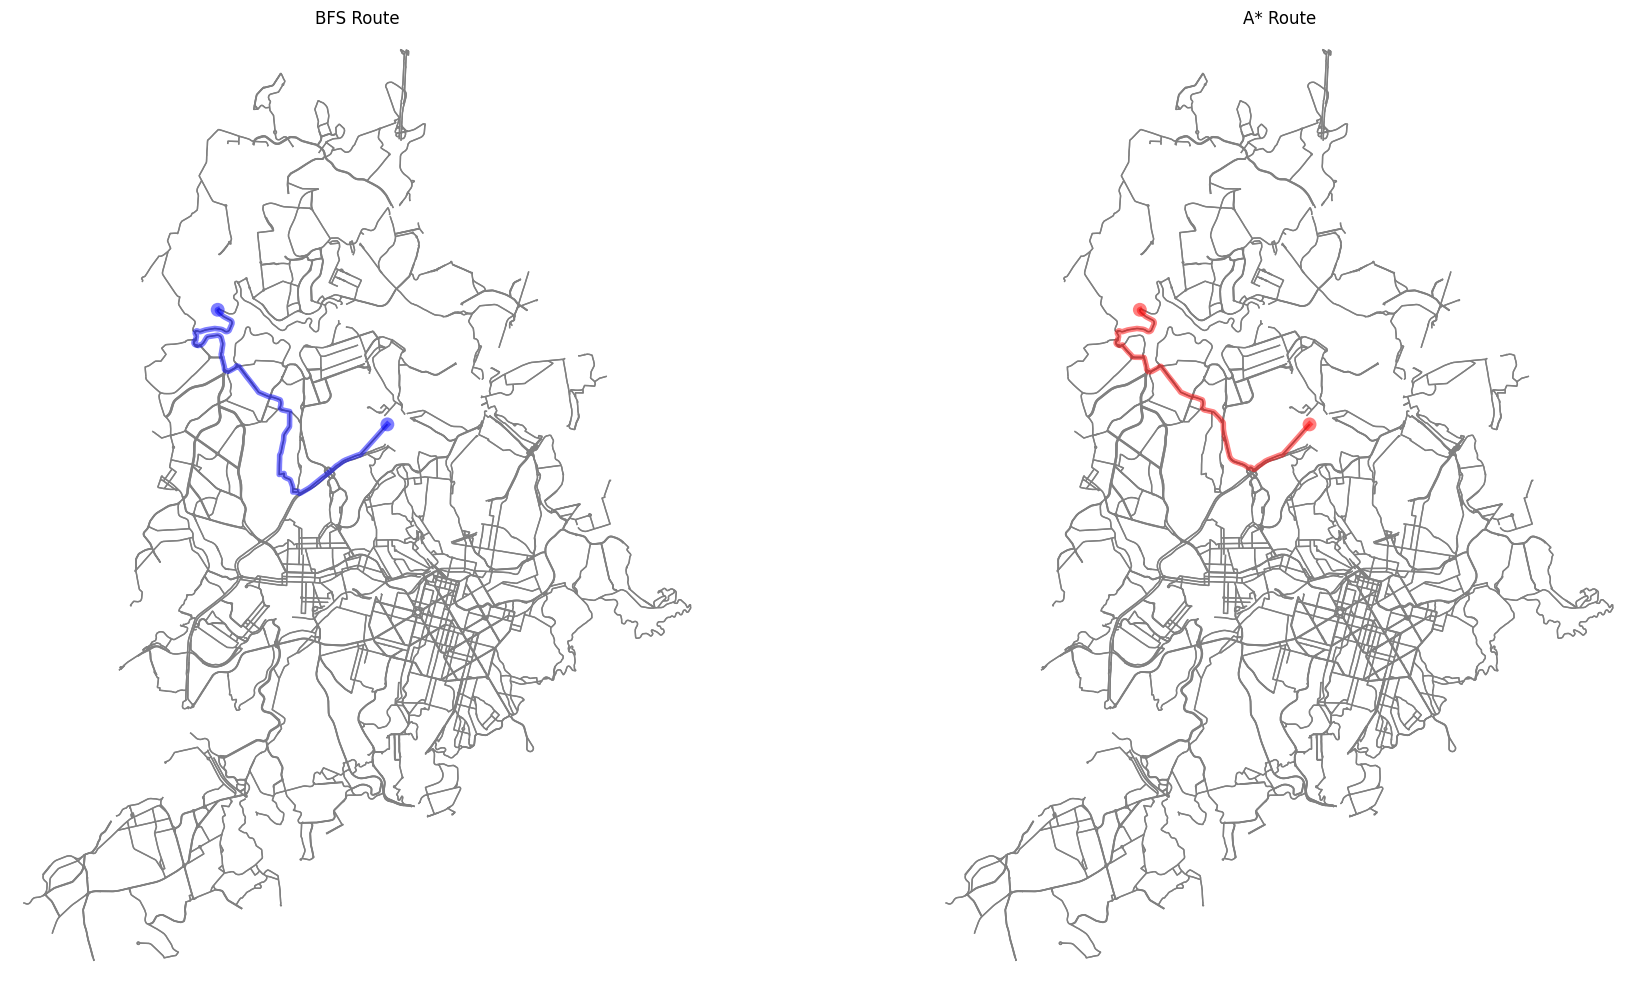

Out - Final answer: Rotas encontradas entre 'Xapuri' e 'Maria das Tranças':

BFS Route:
Path with 41 points: (-19.84546, -43.99953), (-19.84559, -43.99960), (-19.84583, -43.99952), (-19.85083, 
-44.00517), (-19.85111, -44.00557), (-19.85118, -44.00559), (-19.85150, -44.00565), (-19.85248, -44.00533), 
(-19.85313, -44.00544), (-19.85331, -44.00566), (-19.85446, -44.00532), (-19.85454, -44.00505), (-19.85444, 
-44.00437), (-19.85443, -44.00428), (-19.85439, -44.00402), (-19.85621, -43.99846), (-19.85754, -43.99840), 
(-19.85774, -43.99836), (-19.86087, -43.99752), (-19.86099, -43.99728), (-19.85978, -43.99446), (-19.86004, 
-43.99418), (-19.85995, -43.99398), (-19.85989, -43.99383), (-19.86568, -43.98908), (-19.86769, -43.98536), 
(-19.86771, -43.98524), (-19.87025, -43.98251), (-19.87064, -43.98248), (-19.87109, -43.98180), (-19.87145, 
-43.97999), (-19.89119, -43.97914), (-19.89178, -43.97772), (-19.89238, -43.97730), (-19.88778, -43.97035), 
(-19.88720, -43.96956), (-19.88680, -43.96906), (-19.88609, -43.96816), (-19.88248, -43.96086), (-19.88213, 
-43.96050), (-19.87473, -43.95345)

A* Route:
Path with 48 points: (-19.84546, -43.99953), (-19.84559, -43.99960), (-19.84583, -43.99952), (-19.85083, 
-44.00517), (-19.85111, -44.00557), (-19.85118, -44.00559), (-19.85150, -44.00565), (-19.85248, -44.00533), 
(-19.85313, -44.00544), (-19.85331, -44.00566), (-19.85446, -44.00532), (-19.85454, -44.00505), (-19.85444, 
-44.00437), (-19.85443, -44.00428), (-19.85452, -44.00422), (-19.85455, -44.00423), (-19.85735, -44.00160), 
(-19.85745, -44.00146), (-19.85761, -43.99856), (-19.85771, -43.99855), (-19.85776, -43.99846), (-19.85774, 
-43.99836), (-19.86087, -43.99752), (-19.86099, -43.99728), (-19.86128, -43.99727), (-19.86125, -43.99640), 
(-19.86004, -43.99418), (-19.85995, -43.99398), (-19.85989, -43.99383), (-19.86568, -43.98908), (-19.86769, 
-43.98536), (-19.86771, -43.98524), (-19.87025, -43.98251), (-19.87064, -43.98248), (-19.87109, -43.98180), 
(-19.87145, -43.97999), (-19.87356, -43.97756), (-19.87376, -43.97739), (-19.87397, -43.97716), (-19.87411, 
-43.97702), (-19.87444, -43.97687), (-19.87737, -43.97660), (-19.87796, -43.97643), (-19.88557, -43.97047), 
(-19.88609, -43.96816), (-19.88248, -43.96086), (-19.88213, -43.96050), (-19.87473, -43.95345)

[Step 1: Duration 58.51 seconds| Input tokens: 2,074 | Output tokens: 251]

Rotas encontradas entre 'Xapuri' e 'Maria das Tranças':

BFS Route:
Path with 41 points: (-19.84546, -43.99953), (-19.84559, -43.99960), (-19.84583, -43.99952), (-19.85083, -44.00517), (-19.85111, -44.00557), (-19.85118, -44.00559), (-19.85150, -44.00565), (-19.85248, -44.00533), (-19.85313, -44.00544), (-19.85331, -44.00566), (-19.85446, -44.00532), (-19.85454, -44.00505), (-19.85444, -44.00437), (-19.85443, -44.00428), (-19.85439, -44.00402), (-19.85621, -43.99846), (-19.85754, -43.99840), (-19.85774, -43.99836), (-19.86087, -43.99752), (-19.86099, -43.99728), (-19.85978, -43.99446), (-19.86004, -43.99418), (-19.85995, -43.99398), (-19.85989, -43.99383), (-19.86568, -43.98908), (-19.86769, -43.98536), (-19.86771, -43.98524), (-19.87025, -43.98251), (-19.87064, -43.98248), (-19.87109, -43.98180), (-19.87145, -43.97999), (-19.89119, -43.97914), (-19.89178, -43.97772), (-19.89238, -43.97730), (-19.88778, -43.97035), (-19.88720, -43.96956), (-19.88680, -43.96906), (-19.88609, -43.96816),

In [14]:
print("Olá! Eu sou um agente inteligente de rotas para Belo Horizonte.")
print("Posso traçar caminhos entre restaurantes ou locais da cidade usando algoritmos de busca como BFS e A*.")
print("Basta me dizer de onde você quer sair e para onde deseja ir!")
prompt = input("\nDigite seu prompt: ")
resposta = agent.run(prompt)
print(resposta)

In [ ]:
%pip install imageio

In [15]:
import imageio.v2 as imageio
import os


def gerar_gif_da_rota(G, route, nome_saida="rota.gif", cor="blue"):
    if route is None:
        print("Rota vazia, nada para animar.")
        return

    pasta_gif = "gifs"
    os.makedirs(pasta_gif, exist_ok=True)
    caminho_gif = os.path.join(pasta_gif, nome_saida)

    # Pasta temporária para armazenar imagens
    pasta_frames = "frames_temp"
    os.makedirs(pasta_frames, exist_ok=True)

    filenames = []
    for i in range(1, len(route) + 1):
        fig, ax = ox.plot_graph(
            G, show=False, close=False, edge_color='gray', node_size=0)
        partial_route = route[:i]
        ox.plot_graph_route(G, partial_route, ax=ax, route_color=cor,
                            route_linewidth=3, node_size=10, show=False, close=False)
        filename = os.path.join(pasta_frames, f"frame_{i:03d}.png")
        plt.savefig(filename, dpi=100)
        plt.close(fig)
        filenames.append(filename)

    imagens = [imageio.imread(f) for f in filenames]
    imageio.mimsave(caminho_gif, imagens, duration=0.1)

    # Limpar arquivos temporários
    for f in filenames:
        os.remove(f)
    os.rmdir(pasta_frames)

    print(f"GIF salvo em {caminho_gif}")

In [16]:
bfs_route, a_star_route = shortest_path("Xapuri", "Maria das Tranças")
gerar_gif_da_rota(G, bfs_route, nome_saida="bfs.gif", cor="blue")
gerar_gif_da_rota(G, a_star_route, nome_saida="astar.gif", cor="red")

GIF salvo em gifs\bfs.gif
GIF salvo em gifs\astar.gif
